In [1]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Edge

Using TensorFlow backend.


In [3]:
def get_predictions(data):
    #parameters = {'filename': '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_nrt_all_smr_nhc'}
    #parameters = {'filename': '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_old'}
    #parameters = {'filename': '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_nrt_all_smr_nhc_shift_kappa'}
    parameters = {'filename': '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_dshift1_kappa'}
    #parameters = {'filename': '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_nrt_circle_smr_nhc'}
    model = load_model(parameters, path=basepath)
    test_predictions = model.predict(data, batch_size=128).flatten()
    return test_predictions

In [4]:
def plot_vofs(features, number_of_plots, **kwargs):
    if 'per_row' in kwargs:
        per_row = kwargs.get('per_row')
    else:
        per_row = 5
    rows = int(number_of_plots/per_row)
    print()
    if 'size' in kwargs:
        size = 150*kwargs.get('size')
    else:
        size = 150
    fig, ax = plt.subplots(rows, per_row, figsize=(3*per_row, 3*number_of_plots/per_row), dpi=size)
    if rows > 1:
        for idx_st, a_stack in enumerate(ax):
            for idx, a in enumerate(a_stack):
                a.imshow(features[idx+int(idx_st*per_row)], cmap=('Greys_r' if not 'cmap' in kwargs else kwargs.get('cmap')))
                a.get_xaxis().set_ticks([])
                a.get_yaxis().set_ticks([])
                if 'labels' in kwargs:
                    labels=kwargs.get('labels')
                    kappa = labels[idx + int(idx_st*per_row)]

                    if 'hf' in kwargs:
                        hf = kwargs.get('hf')
                        hf = hf[idx + int(idx_st*per_row)]
                        a.set_title(f'hf: {np.round(hf, 3)}, k: {np.round(kappa, 3)}', fontsize=14)
                    else:
                        # a.set_title(f'kappa = {np.round(kappa, 3)}', fontsize=22)
                        a.set_title("kappa = %.3f" % kappa, fontsize=22)
    else:
        idx_st = 0
        if isinstance(ax, np.ndarray):
            for idx, a in enumerate(ax):
                    a.imshow(features[idx+int(idx_st*per_row)], cmap=('Greys_r' if not 'cmap' in kwargs else kwargs.get('cmap')))
                    a.get_xaxis().set_ticks([])
                    a.get_yaxis().set_ticks([])
                    if 'labels' in kwargs:
                        labels=kwargs.get('labels')
                        kappa = labels[idx + int(idx_st*per_row)]

                        if 'hf' in kwargs:
                            hf = kwargs.get('hf')
                            hf = hf[idx + int(idx_st*per_row)]
                            a.set_title(f'hf: {np.round(hf, 3)}, k: {np.round(kappa, 3)}', fontsize=12)
                        else:
                            #a.set_title(f'kappa = {np.round(kappa, 3)}', fontsize=22)
                            a.set_title("kappa = %.3f" % kappa, fontsize=22)
        else:
            a = ax
            if 'cmap' in kwargs:
                vmax = max(np.amax(features), -np.amin(features))
                vmin = -vmax
            else:
                vmax = np.amax(features)
                vmin = np.amin(features)
                    
            axis = a.imshow(features, cmap=('Greys_r' if not 'cmap' in kwargs else kwargs.get('cmap')), vmin=vmin, vmax=vmax)
            a.get_xaxis().set_ticks([])
            a.get_yaxis().set_ticks([])
            if 'cmap' in kwargs:
                cbar = plt.colorbar(axis)
            if 'labels' in kwargs:
                labels=kwargs.get('labels')
                kappa = labels

                if 'hf' in kwargs:
                    hf = kwargs.get('hf')
                    a.set_title(f'hf: {np.round(hf, 3)}, k: {np.round(kappa, 3)}', fontsize=12)
                else:
                    #a.set_title(f'kappa = {np.round(kappa, 3)}', fontsize=22)
                    a.set_title("kappa = %.3f" % kappa, fontsize=22)
                    
    fig.tight_layout()

In [5]:
def create_plot(labels, predictions, color, parameters, **kwargs):
    # Create plot
    fgsz = (10*kwargs.get('scale') if 'scale' in kwargs else 10)
    fig, ax = plt.subplots(1, 1, figsize=(fgsz, fgsz))

    # Create scatterplot test_predictions vs test_labels
    alpha = 0.1
    marker = kwargs.get('marker') if 'marker' in kwargs else ','
    size = (kwargs.get('size') if 'size' in kwargs else 1)
    size = (size*kwargs.get('scale') if 'scale' in kwargs else size)
    plt.scatter(labels, predictions, alpha=alpha, color=color, edgecolors='none', marker=marker, s=size)  # darkseagreen
    
    if 'axis' in kwargs:
        axis = kwargs.get('axis')
        if axis == 'equal':
            lims = [[min(predictions), max(predictions)], [min(predictions), max(predictions)]]
            #lims = [[min(labels), max(labels)], [min(labels), max(labels)]]
            # Plot the 45 degree line
            ax.plot(lims[0], lims[0], color='gray')
        else:
            lims = [[min(labels), max(labels)], [min(predictions), max(predictions)]]
        
    else:
        lims = [[min(predictions), max(predictions)], [min(predictions), max(predictions)]]
        # Plot the 45 degree line
        ax.plot(lims[0], lims[0], color='gray')
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
 
    fig.tight_layout()

    return fig, ax


Shape:	(100, 82)
[100, 10, 9]
[9, 9]
(100,)
(100, 81)
max:	0.425,	min:	-0.444



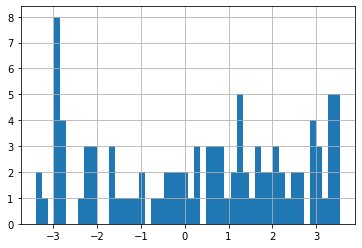

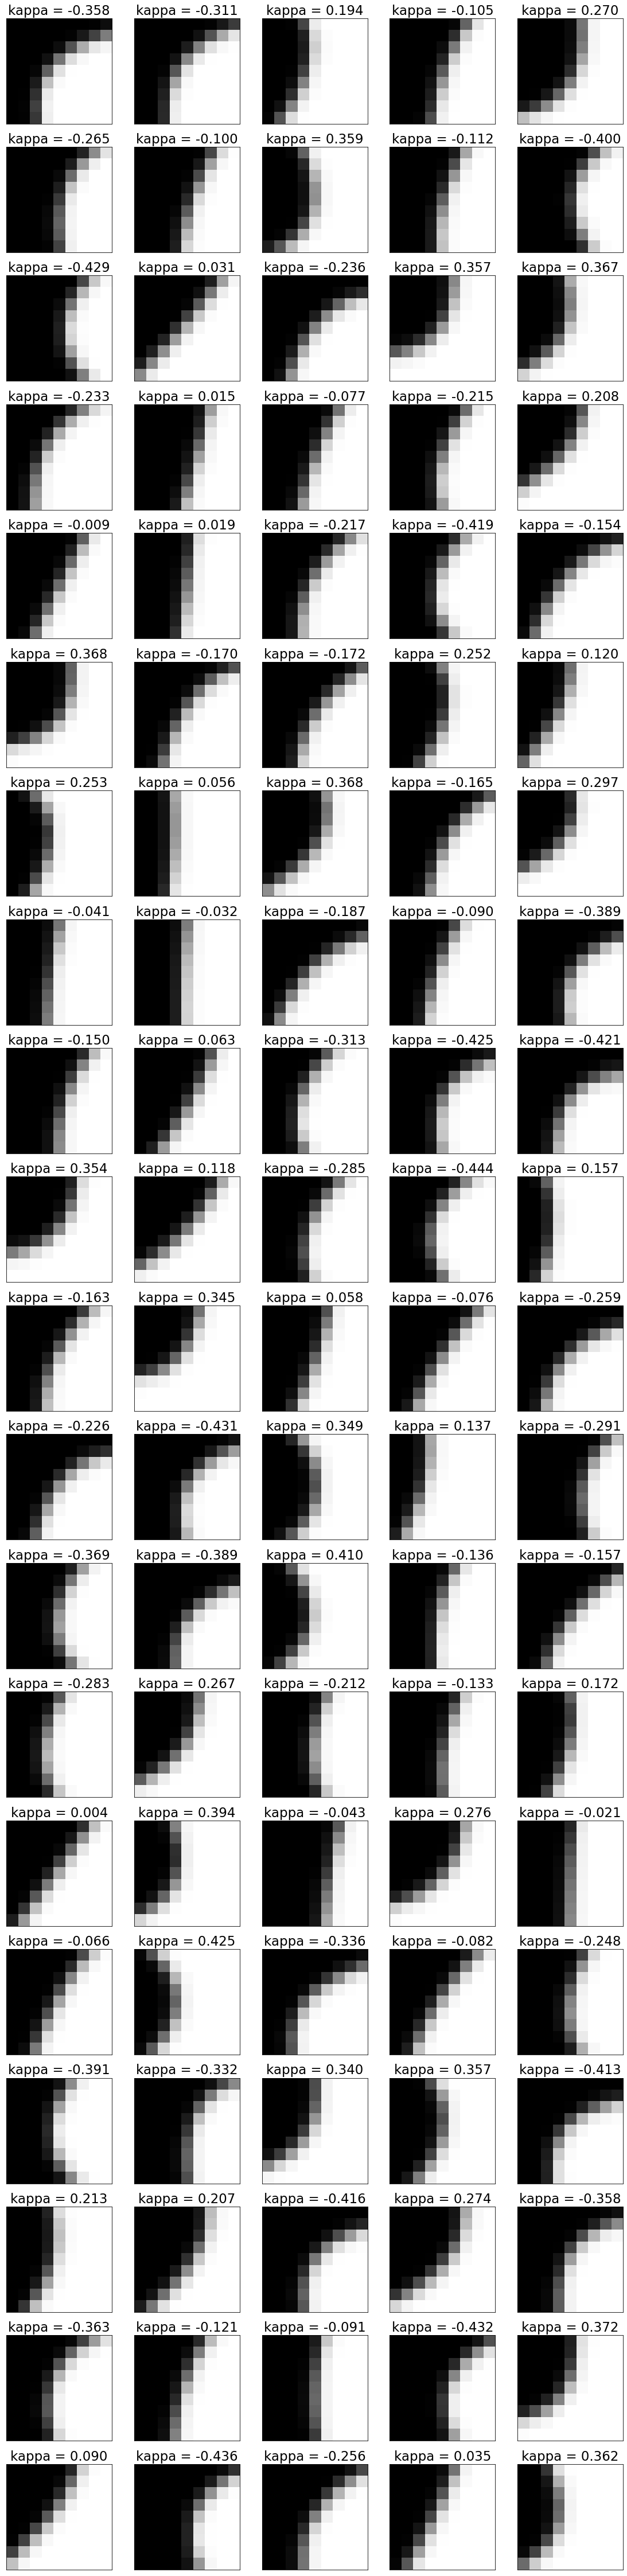

In [8]:


#filename = 'data_5x5_eqk_neg_ellre.feather'
#filename = 'data_7x7_eqk_neg_cir_smr_shift1.feather'
filename = 'data_9x9_eqk_neg_ell_smr_shift1.feather'
#filename = 'data_7x7_eqk_neg_cir_smr_shift1b.feather'
#filename = 'data_7x7_eqk_neg_ell_smr.feather'
file = pd.read_feather(filename)
print(f'Shape:\t{file.shape}')
# file = file[(file.iloc[:, 0] < -(0.5/8-0.0002)) & (file.iloc[:, 0] > -(0.5/8+0.0002))]
#file = file[(np.abs(file.iloc[:, 0]) < 0.1)]

print([int(file.iloc[:, 1:].shape[0]), int(np.sqrt(file.iloc[:, 1:].shape[0])), int(np.sqrt(file.iloc[:, 1:].shape[1]))])

st_sz = [int(np.sqrt(file.iloc[:, 1:].shape[1])), int(np.sqrt(file.iloc[:, 1:].shape[1]))]
print(st_sz)
parameters = {'stencil_size': st_sz, 'angle': False}

# Create pipeline
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    ('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]
    #('edge', Edge(parameters=parameters)),  # Output: [labels, data, angle_matrix]
])
# Execute pipeline
dataset = file
[labels, features, angle] = data_pipeline.fit_transform(dataset)

# Create pipeline
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
])
# Execute pipeline
[testlabels, testdata] = data_pipeline.fit_transform(dataset)
print(testlabels.shape)
print(testdata.shape)

'''
debug = False
if not debug:
    features = file.iloc[:, 1:]
    labels = file.iloc[:, 0]
    dataset = file
else:
    pt_x = file.iloc[:, 0]
    pt_y = file.iloc[:, 1]
    e = file.iloc[:, 2]
    r = file.iloc[:, 3]
    labels = file.iloc[:, 4]
    features = file.iloc[:, 5:]
'''
print(f'max:\t{np.round(max(labels),3)},\tmin:\t{np.round(min(labels),3)}')

features_plt = np.reshape(features, (int(features.shape[0]), int(np.sqrt(features.shape[1])), int(np.sqrt(features.shape[1]))))
#print(f'shape: {features.shape}')
#print(features[0])
#features_plt = features[:, :49]
#features_plt = features[:, 49:]
#print(f'shape: {features_plt.shape}')
#features_plt = np.reshape(features_plt, (int(features.shape[0]), 7, 7))

#predictions_dg = get_predictions(features)*2

pd.Series(-labels*2*4).hist(bins=50)
#pd.Series(-predictions_dg*4).hist(bins=200, alpha=0.5)
# plot_vofs(features, labels.values, 24, per_row = 7)
plot_vofs(features_plt, 100, labels=labels, per_row = 5, size=0.5)
#plot_vofs(features_plt, 100, labels=-predictions_dg*4, per_row = 5, size=0.5)


In [7]:
create_plot(labels, predictions_dg, color='crimson', parameters=parameters, marker='.', size = 1, axis = 'notequal', scale=0.75)

NameError: name 'predictions_dg' is not defined

In [ ]:
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers
folder = 'output_all_rot_128'
#folder = 'output_circle_128'
vector_c = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', folder, 'output_c.txt'), skiprows=1, dtype=np.float).values
vector_last = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', folder, 'output_last.txt'), skiprows=1, dtype=np.float).values
vector_last = np.reshape(vector_last, (vector_last.shape[0],))
vector_cm = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', folder, 'output_cm.txt'), skiprows=1, dtype=np.float).values
vector_cds = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', 'output_cds.txt'), skiprows=1, dtype=np.float).values[:, 0]

parameters = {'stencil_size': [7, 7], 'angle': False}
# Create pipeline
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    ('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]
])
# Execute pipeline
pipe_c = np.reshape(np.flip(np.reshape(vector_c, (vector_c.shape[0], 7, 7)), axis=1), (vector_c.shape[0], 49))
#pipe_c = np.reshape(vector_c, (vector_c.shape[0], 49))
pipe_c = np.concatenate((np.reshape(vector_last, (vector_last.shape[0], 1)), pipe_c), axis = 1)
pipe_c = pd.DataFrame(pipe_c)
[c_lab, c_feat, c_ang] = data_pipeline.fit_transform(pipe_c)


gitweit_selbst = 1/1000
gitweit_fnb = 8/128
faktor = -0.5*1/gitweit_fnb
vector_last = vector_last#*-0.5*1/gitweit_fnb

print(f'avg: {sum(vector_last)/len(vector_last)}')

if False:
    indices = np.where(vector_last > 0.8)
    vector_c = vector_c[indices[0], :]
    vector_cm = vector_cm[indices[0], :]
    vector_last = vector_last[indices]
    print(vector_cm.shape)
else:
    # Get random values
    np.random.seed(42)
    indices = np.random.permutation(vector_c.shape[0])
    vector_c = vector_c[indices, :]
    vector_cm = vector_cm[indices, :]
    vector_last = vector_last[indices]


plot_vofs(np.reshape(vector_c, (vector_c.shape[0],7,7)), 5, labels=vector_last, per_row=5)
#plot_vofs(np.reshape(c_feat, (c_feat.shape[0],7,7)), 5, labels=vector_last, per_row=5)

In [ ]:
print(vector_cm.shape)
plot_vofs(np.reshape(vector_cm, (vector_cm.shape[0],7,7)), 20, labels=vector_last, per_row=5)

In [ ]:
##############################
### Rumspielen bitte unten ###
##############################

print(vector_cm.shape)
comp_idx = 10
comp_cm = np.reshape(vector_cm[comp_idx, :], (7, 7))
comp_c = np.reshape(c_feat[comp_idx, :], (7, 7))
comp_feat = np.reshape(features, (features.shape[0], 7, 7))
resi = comp_cm - comp_feat
# comp_cm = features[4, :]
# resi_test = np.reshape(comp_cm, (1, 49)) - np.reshape(features[4, :], (1, 49))

if False:
    closest = np.sum(np.abs(resi), axis=(1, 2))
    hier = np.where((closest - min(closest)) == 0)[0]

else:
    closest = np.sum(np.abs(resi), axis=1)[:, 3]
    hier = np.where((closest - min(closest)) == 0)[0]

cor = np.zeros((7, 7))
cor[6, 4] = 0.12
cor[5, 4] = 0.1
cor[5, 4] = 0.05
pred_feat = comp_cm + cor
comp_pred = get_predictions(np.reshape(pred_feat, (1, 49)))
print(f'\nPrediction: {comp_pred[0]*faktor}')

print('\nClosest stencil in dataset')
print(np.reshape(features[hier], (7, 7)))
print('\nto real stencil cm:')
print(np.reshape(np.round(comp_cm, 5), (7, 7)))
print('c:')
print(np.reshape(np.round(comp_c, 5), (7, 7)))
print(f'\nwith difference {np.round(np.sum(np.abs(resi[hier])), 5)}')
print(np.reshape(np.round(resi[hier], 5), (7, 7)))



plot_vofs(comp_feat[hier][0], 1, labels=labels[hier]*faktor, per_row = 1, size=0.5)
plot_vofs(comp_cm, 1, labels=vector_last[comp_idx], per_row = 1, size=0.5)
plot_vofs(comp_c, 1, labels=get_predictions(np.reshape(comp_c, (1, 49)))[0]*faktor, per_row = 1, size=0.5)
plot_vofs(resi[hier][0], 1, per_row = 1, size=0.6, cmap='RdBu')

In [ ]:
print(vector_cm.shape)
comp_idx = 10
comp_cm = np.reshape(vector_cm[comp_idx, :], (7, 7))
comp_c = np.reshape(c_feat[comp_idx, :], (7, 7))
comp_feat = np.reshape(features, (features.shape[0], 7, 7))
resi = comp_c - comp_feat
# comp_cm = features[4, :]
# resi_test = np.reshape(comp_cm, (1, 49)) - np.reshape(features[4, :], (1, 49))

if True:
    closest = np.sum(np.abs(resi), axis=(1, 2))
    hier = np.where((closest - min(closest)) == 0)[0]

else:
    closest = np.sum(np.abs(resi), axis=1)[:, 3]
    hier = np.where((closest - min(closest)) == 0)[0]

cor = np.zeros((7, 7))
cor[6, 4] = 0.12
cor[5, 4] = 0.1
cor[5, 4] = 0.05
pred_feat = comp_cm + cor
comp_pred = get_predictions(np.reshape(pred_feat, (1, 49)))
print(f'\nPrediction: {comp_pred[0]*faktor}')

print('\nClosest stencil in dataset')
print(np.reshape(features[hier], (7, 7)))
print('\nto real stencil cm:')
print(np.reshape(np.round(comp_cm, 5), (7, 7)))
print('c:')
print(np.reshape(np.round(comp_c, 5), (7, 7)))
print(f'\nwith difference {np.round(np.sum(np.abs(resi[hier])), 5)}')
print(np.reshape(np.round(resi[hier], 5), (7, 7)))



plot_vofs(comp_feat[hier][0], 1, labels=labels[hier]*faktor, per_row = 1, size=0.5)
plot_vofs(comp_cm, 1, labels=vector_last[comp_idx], per_row = 1, size=0.5)
plot_vofs(comp_c, 1, labels=get_predictions(np.reshape(comp_c, (1, 49)))[0]*faktor, per_row = 1, size=0.5)
plot_vofs(resi[hier][0], 1, per_row = 1, size=0.6, cmap='RdBu')

In [ ]:
fortran_predictions = get_predictions(vector_cm)*faktor  # vector_last*faktor # 
fortran_predictions_2 = get_predictions(c_feat)*faktor
idx = list(range(0,9))

print(f'Mittelwert fortran:\t{np.round(sum(fortran_predictions)/fortran_predictions.shape[0], 4)}')
print(f'Mittelwert c:\t\t{np.round(sum(fortran_predictions_2)/fortran_predictions_2.shape[0], 4)}')

roud = 3
pd.Series(np.round(fortran_predictions, roud)).hist(bins=50, color='b', label='cm', alpha=0.5)
pd.Series(np.round(fortran_predictions_2, roud)).hist(bins=50, color='r', label='c', alpha=0.5)

# Vergleich ml cds
# pd.Series(np.round(vector_last, roud)).hist(bins=50, alpha=1, color='b', label='ml')
# pd.Series(np.round(vector_cds, roud)).hist(bins=100, alpha=1, color='r', label='cds')
plt.legend()

#pd.Series(predictions_dg).hist(bins=50, alpha=0.5)